In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from banana_env import BananaEnv
import numpy as np

In [ ]:
env = BananaEnv("Banana_Windows_x86_64\Banana.exe")

In [ ]:
# reset the environment
obs = env.reset(options={"train_mode": True})

# number of actions
action_size = env.nA
print('Number of actions:', action_size)

# examine the state space 
state = env.nS
print('States look like:', state)
state_size = len(obs)
print('States have length:', state_size)

In [ ]:
state = env.reset(options={"train_mode": False}) # reset the environment
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    next_state, reward, done, _ = env.step(action)        # send the action to the environment
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

In [ ]:
env.close()

Lets Go

In [6]:
from dqn_agent import Agent
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from banana_env import BananaEnv
import numpy as np

%load_ext autoreload
%autoreload 2

env = BananaEnv("Banana_Windows_x86_64\Banana.exe")
seed = 0

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [7]:
# adapted from https://github.com/huggingface/transformers/blob/6e535425feae20ca61a8b10ae5e8a7fab4d394ba/src/transformers/optimization.py#L104

from dataclasses import dataclass
import math

@dataclass
class CosWarmupScheduler:
    num_warmup_steps: int
    num_training_steps: int 
    start_val: float
    end_val: float
    current_step: int = 0
    num_cycles: float = 0.5

    def step(self) -> float:
        if self.current_step < self.num_warmup_steps:
            r = self.start_val
        elif self.current_step > self.num_training_steps:
            r = self.end_val
        else:        
            progress = float(self.current_step - self.num_warmup_steps) / float(max(1, self.num_training_steps - self.num_warmup_steps))
            r = max(self.end_val, 0.5 * (1.0 + math.cos(math.pi * float(self.num_cycles) * 2.0 * progress)))
        self.current_step += 1
        return r
    

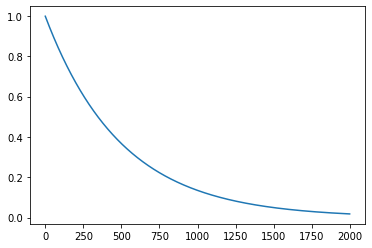

In [8]:
i=1
plt.plot([i:=i*0.998 for j in range(2000)])

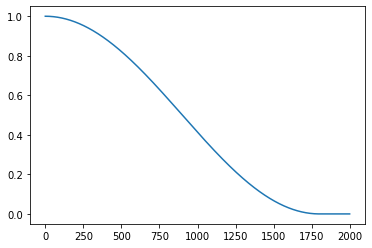

In [9]:
eps_scheduler = CosWarmupScheduler(0, 1800, 1, 0)
plt.plot([eps_scheduler.step() for i in range(2000)])

QNetworkMlp(
  (net): Sequential(
    (0): Linear(in_features=37, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=4, bias=True)
  )
)
Episode 100	Average Score: -0.05; Eps: 0.8169296710790511
Episode 200	Average Score: 1.22; Eps: 0.6687115105103473
Episode 300	Average Score: 3.08; Eps: 0.5473850444168268
Episode 400	Average Score: 4.71; Eps: 0.448071226742515
Episode 500	Average Score: 6.33; Eps: 0.36677623234744455
Episode 600	Average Score: 8.07; Eps: 0.3002308485483078
Episode 700	Average Score: 9.02; Eps: 0.24575900636508355
Episode 800	Average Score: 10.89; Eps: 0.20117016456366946
Episode 900	Average Score: 11.26; Eps: 0.16467121880552807
Episode 1000	Average Score: 11.96; Eps: 0.13479439340178997
Episode 11

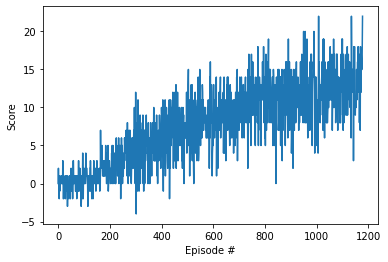

CPU times: total: 1h 54min
Wall time: 33min 16s


In [10]:
%%time

agent = Agent(state_size=env.nS, action_size=env.nA, seed=seed)

print(agent.qnetwork_local)
def dqn(n_episodes=2000):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    #eps_scheduler = CosWarmupScheduler(0, 1800, 1, 0)  # initialize epsilon scheduler
    i=1
    eps_vals = [i:=i*0.998 for _ in range(n_episodes + 10)]

    for i_episode in range(1, n_episodes+1):
        state = env.reset(options={"train_mode": True})
        done = False
        score = 0
        eps = eps_vals[i_episode]
        while not done:
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}; Eps: {:.3f}'.format(i_episode, np.mean(scores_window), eps), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}; Eps: {}'.format(i_episode, np.mean(scores_window), eps))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()
#env.close()
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

pip install stable_baselines3